<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/PlanarSLAMExample_lbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loopy Belief Propagation

Recently, **loopy belief propagation** or LBP has become trendy again because it might a good fit for highly parallel, distributed processing in chips like GraphCore.

In this example we re-create the planar SLAM example, and show how LBP can be viewed as repeated elimination in the factor graph, and how it can be seen as the "dual" of Gibbs sampling, which adopts dual elimination strategy.

**Important note Apr 30 2022: this still contains a bug in LBP**

In [1]:
%pip -q install gtbook  # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
from math import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtbook.display import show
from gtbook.gaussian import sample_bayes_net, sample_conditional
from gtbook.driving import planar_example, marginals_figure
from gtsam import Point2, Pose2, Rot2, noiseModel

## Setting up a non-linear SLAM Example

Below we re-create a similar factor graph as in `PlanarSLAMExample`:

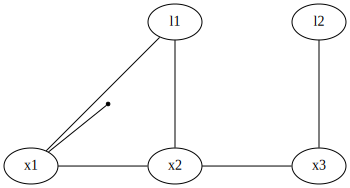

In [3]:
graph, truth, keys = planar_example()
x1, x2, x3, l1, l2 = keys
show(graph, truth, binary_edges=True)

As always, we can calculate and plot covariance ellipses which show the Laplace approximation graphically.

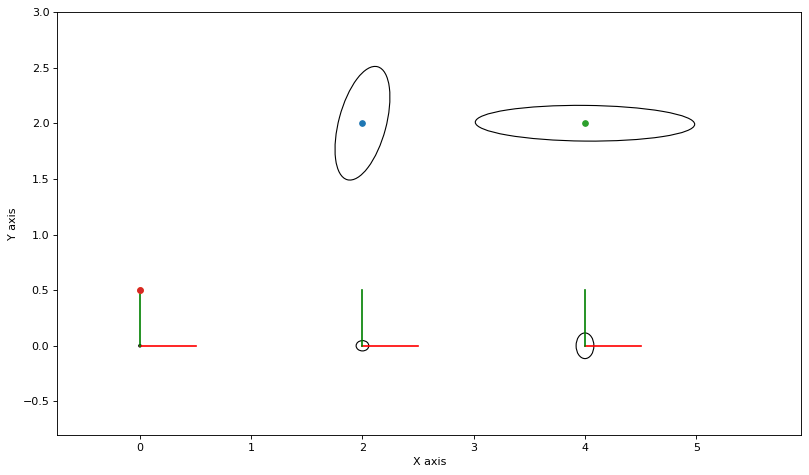

In [4]:
marginals = gtsam.Marginals(graph, truth)
marginals_figure(truth, marginals, keys)

## Loopy Belief Propagation

We initialize a set of individual *Gaussian* factors $q(x_j)$ or *beliefs*, one for each variable. LBP is a fixed point algorithm to minimize the KL $D_\text{KL}(p||q)$ divergence between the true posterior $p(X|Z)$ and the variational approximation

$$
q(X) = \prod_j q(x_j)
$$

We repeatedly:

- pick a variable $x_j$ at random;
- consider the Markov blanket of $x_j$, the factor graph fragment $\phi(x_j, X_j)$ where $X_j$ is the separator;
- augment the factor graph fragment with beliefs on all $x_k\in X_j$, *except* $q(x_j)$;
- eliminate the separator $X_j$ by factorizing $\phi(x_j, X_j) = p(X_j|x_j)q'(x_j)$;
- assign $q(x_j) \leftarrow q'(x_j)$ to be the new belief on $x_j$.

We first cache all Markov blankets:

In [5]:
markov_blankets = defaultdict(gtsam.NonlinearFactorGraph)
for i in range(graph.size()):
    factor = graph.at(i)
    for j in factor.keys():
        markov_blankets[j].add(factor)

Here are the Markov blankets for $l_2$ (simple) and $x_2$ (complex):

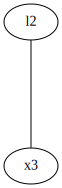

In [6]:
show(markov_blankets[l2], truth, binary_edges=True)

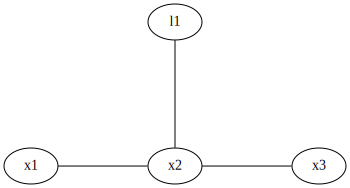

In [7]:
show(markov_blankets[x2], truth, binary_edges=True)

We initialize the beliefs $q_j(x_j)$ on the manifold, which we do in *information form* by using a `HessianFactor`, whose constructor reads as follows:

```c++
/** Construct a unary factor.  G is the quadratic term (Hessian matrix), g
* the linear term (a vector), and f the constant term.  The quadratic
* error is:
* 0.5*(f - 2*x'*g + x'*G*x)
*/
HessianFactor(Key j, const Matrix& G, const Vector& g, double f);
```

We will initialize with an identity Hessian/information matrix $G$. The entire LPB code is then:

In [8]:
def lbp(x0:gtsam.Values, hook=None, N=100):
    """Perform loopy belief propagation with initial estimate x."""
    x = gtsam.Values(x0)
    error = graph.error(x)
    q = {key: gtsam.HessianFactor(key, G=np.eye(n), g=5*np.zeros(
        (n, 1)), f=0) for key, n in zip(keys, [3, 3, 3, 2, 2])}
    hook(0, None, x, q, error)

    def update(j:int, x:gtsam.Values):
        # Get linearized Gaussian Markov blanket and augment with beliefs
        augmented_graph = markov_blankets[j].linearize(x)
        augmented_keys = augmented_graph.keys()
        for k in keys:
            if k != j and augmented_keys.count(k):
                augmented_graph.add(q[k])
        try:
            # Eliminate with x_j eliminated last:
            ordering = gtsam.Ordering.ColamdConstrainedLastGaussianFactorGraph(
                augmented_graph, [j])
            gbn = augmented_graph.eliminateSequential(ordering)
            q_prime = gbn.at(gbn.size()-1)
            # move on the manifold
            delta = q_prime.solve(gtsam.VectorValues())
            new_x = x.retract(delta)
            n = len(delta.at(j))
            P = np.linalg.inv(q_prime.information())
            q[j] = gtsam.HessianFactor(j, np.zeros((n,)), P)
            return new_x
        except:
            return None
                    
    for it in range(1, N):
        # choose a variable whose belief to update
        j = keys[rng.choice(5)]
        new_x = update(j, x)
        if new_x is not None:
            error = graph.error(new_x)
            hook(it, j, x, q, error)
            x = new_x
            if error < 1e-1:
                break
    return x, q

We then initialize with either the ground truth or some random values:

In [9]:
rng = np.random.default_rng(42)
if False:
    initial = gtsam.Values(truth)
else:
    initial = gtsam.Values()
    initial.insert(x1, Pose2(2, 1, 0).retract(0.1*rng.random((3,))))
    initial.insert(x2, Pose2(2, 1, 0).retract(0.1*rng.random((3,))))
    initial.insert(x3, Pose2(2, 1, 0).retract(0.1*rng.random((3,))))
    initial.insert(l1, Point2(2, 1)+rng.random((2,)))
    initial.insert(l2, Point2(2, 1)+rng.random((2,)))

it=0, initial error is 28739.727972505574
it=1, updated x1, error now 2172.712772099904
it=2, updated l1, error now 2148.902547221964
it=3, updated l1, error now 2242.902395962602
it=4, updated x3, error now 2461.23010839909
it=5, updated x3, error now 2387.7091084856806
it=6, updated l2, error now 2368.7729226713204
it=7, updated x1, error now 2364.5674076661253
it=8, updated l1, error now 2253.1975732862534
it=9, updated x2, error now 258.1741359466857
it=10, updated x1, error now 258.170500746144
it=11, updated x3, error now 44.554860079561365
it=12, updated l2, error now 24.990611403809826
it=13, updated l1, error now 24.247842549067705
it=14, updated l1, error now 23.61965973616679
it=15, updated l1, error now 23.605829507065334
it=16, updated l1, error now 23.605818885642304
it=17, updated x3, error now 1.9303914297423215
it=18, updated x1, error now 1.8494706291954204
it=19, updated l2, error now 1.7972337283880535
it=20, updated x3, error now 1.7439552488322032
it=21, updated x

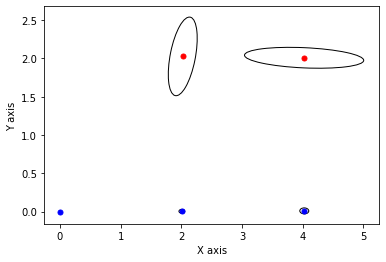

In [10]:
def print_hook(it, j, x, q, error):
    if it==0:
        print(f"{it=}, initial error is {error}")
    else:
        print(f"{it=}, updated {gtsam.DefaultKeyFormatter(j)}, error now {error}")

rng = np.random.default_rng(42)
x, q = lbp(initial, print_hook)

# plot final state
for j in keys[:3]:
    P = np.linalg.inv(q[j].information())
    gtsam_plot.plot_point2(0, x.atPose2(j).translation(), 'b', P)
for j in keys[3:]:
    P = np.linalg.inv(q[j].information())
    gtsam_plot.plot_point2(0, x.atPoint2(j), 'r', P)

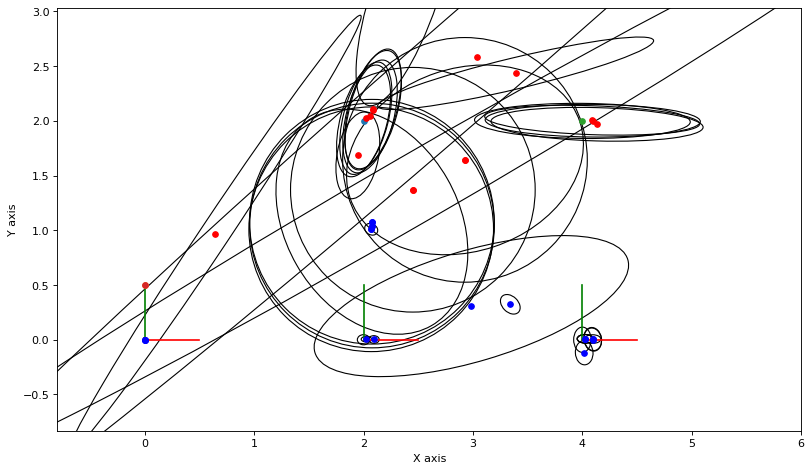

In [11]:
def plot_ellipse(j, x, q):
    P = np.linalg.inv(q[j].information())
    if j in {x1, x2, x3}:
        gtsam_plot.plot_point2(0, x.atPose2(j).translation(), 'b', P)
    else:
        gtsam_plot.plot_point2(0, x.atPoint2(j), 'r', P)
        
def ellipse_hook(it, j, x, q, error):
    if it==0:
        for k in keys: plot_ellipse(k, x, q)
    else:
        plot_ellipse(j, x, q)
        
rng = np.random.default_rng(42)
marginals_figure(truth, marginals, keys)
x = gtsam.Values(initial)
x, q = lbp(x, ellipse_hook)

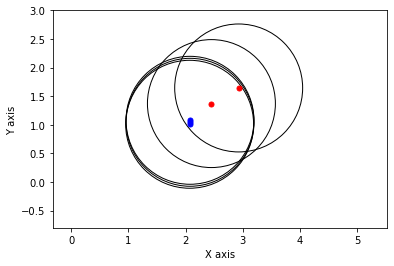

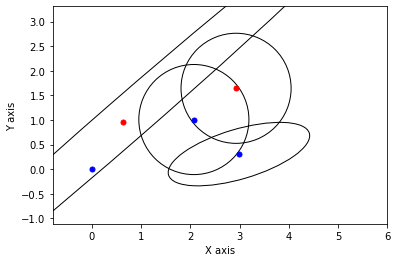

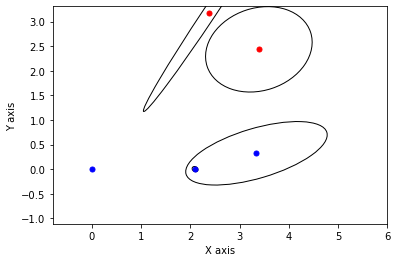

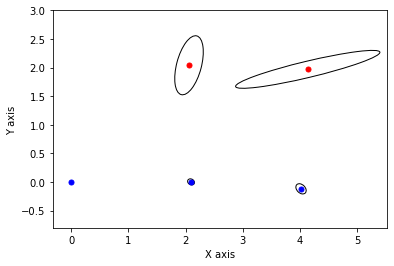

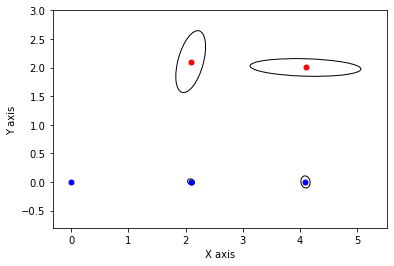

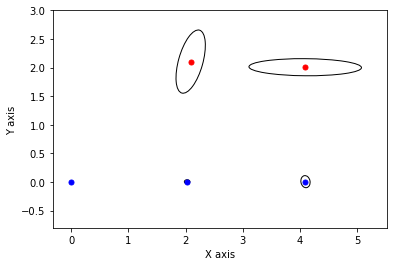

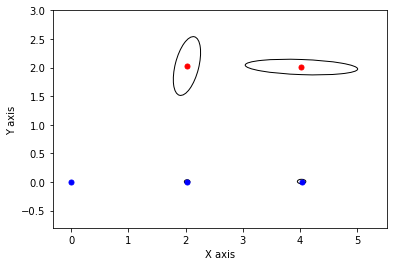

In [12]:
def show_frame(it, j, x, q, error):
    if it % 5 != 0: return
    for k in keys:
        P = np.linalg.inv(q[k].information())
        if k in [x1,x2,x3]:
            gtsam_plot.plot_point2(0, x.atPose2(k).translation(), 'b', P)
        else:
            gtsam_plot.plot_point2(0, x.atPoint2(k), 'r', P)
    plt.axis('equal')
    plt.xlim([-0.8, 6])
    plt.ylim([-0.8, 3])
    plt.show()

rng = np.random.default_rng(42)
x, q = lbp(gtsam.Values(initial), show_frame)

## Gibbs Sampling

Gibbs sampling is a variant of Markov Chain Monte Carlo sampling that always accepts any proposal.


We repeatedly:

- pick a variable $x_j$ at random;
- consider the Markov blanket of $x_j$, the factor graph fragment $\phi(x_j, X_j)$ where $X_j$ is the separator;
- eliminate the variable $x_j$ by factorizing $\phi(x_j, X_j) = p(x_j|X_j)\phi(X_j)$;
- sample $x_j$ $\phi(x_j, X_j)$.

We will need:

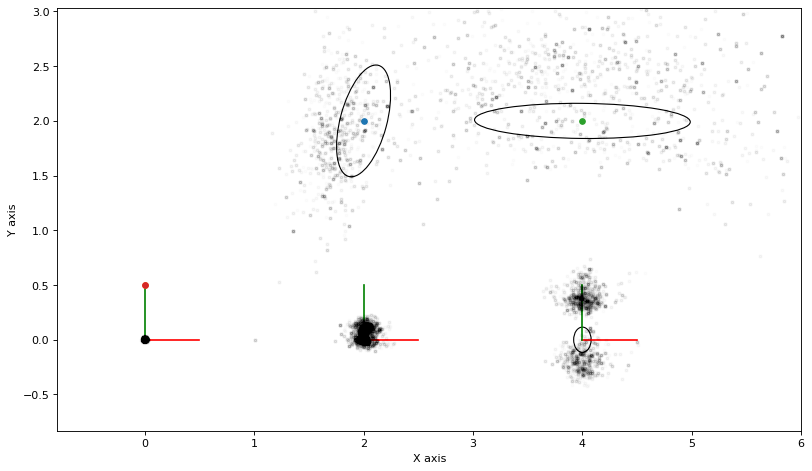

In [13]:
rng = np.random.default_rng(42)


def plot_sample(manifold_sample, alpha=0.1):
    points = np.empty((2, 5))
    for i in [1, 2, 3]:
        points[:, i -
               1] = manifold_sample.atPose2(gtsam.symbol('x', i)).translation()
    for j in [1, 2]:
        points[:, j+2] = manifold_sample.atPoint2(gtsam.symbol('l', j))
    plt.plot(points[0], points[1], 'k.', markersize=5, alpha=alpha)
    return points


def proposal(x, j):
    """Propose via Gibbs sampling"""
    # Get linearized Gaussian Markov blanket
    local_graph = markov_blankets[j].linearize(x)
    # Eliminate just x_j:
    ordering = gtsam.Ordering()
    ordering.push_back(j)
    try:  # eliminate, might fail if singular
        gbn, _ = local_graph.eliminatePartialSequential(ordering)
        # sample x_j and propose a new manifold sample
        conditional = gbn.at(0)
        vvj = gtsam.VectorValues()
        vvj.insert(j, sample_conditional(conditional, 1))
        return x.retract(vvj)
    except:
        return x


# Start with MAP estimate
y = gtsam.Values(truth)
N = 10000
marginals_figure(truth, marginals, keys)
for it in range(N):
    # choose a variable to perturb
    j = keys[rng.choice(5)]
    y = proposal(y, j)
    if it > N//2:
        plot_sample(y, alpha=0.01)

## Corrected Gibbs Sampling

Above we pretended elimination yielded the correct conditional on $x_j$ given its separator. 
Unfortunately, calculating the conditional probability $P(x_j|X_j)$ exactly is again a hard problem, and sampling from it can be expensive as well. We correct this by rejection a fraction of the proposals, Metropolis style:

Then we run Metropolis sampler where the proposal randomly picks a variable to perturb, and then uses the local factor graph to calculate the acceptance ratio.

nr_accepted=8536


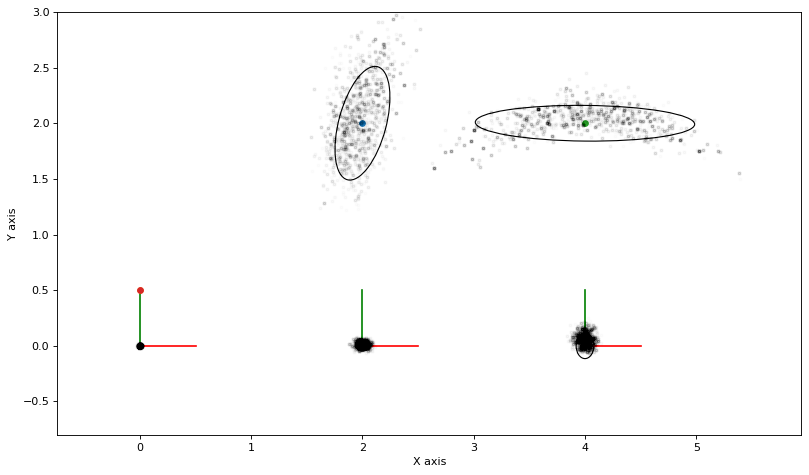

In [14]:
rng = np.random.default_rng(42)

def accept(log_a):
    """calculate acceptance, with some care to avoid overflow."""
    if log_a >= 0:
        return True
    if log_a < -10:
        return False
    return rng.uniform() < math.exp(log_a)

# Start with MAP estimate
z = gtsam.Values(truth)
N = 15000
marginals_figure(truth, marginals, keys)
nr_accepted = 0
for it in range(N):
    # choose a variable to perturb
    j = keys[rng.choice(5)]
    p = proposal(z, j)
    # calculate local acceptance ratio
    log_a = markov_blankets[j].error(z) - markov_blankets[j].error(p)
    if accept(log_a):
        nr_accepted += 1
        z = p
        if it>N//2:
            plot_sample(z, alpha=0.01)

print(f"nr_accepted={nr_accepted}")